In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, RegexpTokenizer
import nltk
nltk.download('punkt')

from nltk.stem.porter import PorterStemmer
stemmer= PorterStemmer() # create the instance

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.sentiment import SentimentIntensityAnalyzer
SIA= SentimentIntensityAnalyzer() # create the instance

[nltk_data] Downloading package punkt to C:\Users\hchih...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\hchih...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# get dialogue
def get_dialogue_df(script):
    clean= []    
    if '#' in script[0]:
        for n, para in enumerate(script):
#             if n<20:
                if '#' in para: pass
                else: clean.append(para)
                    
    else: 
        for n, para in enumerate(script):
#             if n<20:
                dp= []
                for i, ele in enumerate(para):
                    if ele== '[': 
                            dp.append(i-1) 
                    elif ele== ']': 
                            dp.append(i+2)
                if (len(dp)== 0):
                    if len(para)== 1: # no content no [] 
                        pass
                    else: 
                        clean.append(para) # content with no [] 
                elif (len(dp)!= 0) and (dp[0]== -1):
                    pass
                else:
                    for i in range(len(dp), 0, -2):
                        para= para.replace(para[dp[i-2]:dp[i-1]-1],' ')
                    clean.append(para)
    
    # seperate character & lines, save to dataframe
    chct_lst= []
    ln_lst=[]    
    for i, ele in enumerate(clean):    
#         if i<30:
            ele= ele.lower().replace('\n',' ')
            if len(ele.split(':'))== 2:
                chct= ele.split(':', 1)[0]
                chct_lst.append(chct)
                line= ele.split(':', 1)[1]
                ln_lst.append(line)
    df= pd.concat([pd.DataFrame({'Character': chct_lst}),
                pd.DataFrame({'Line': ln_lst})], axis= 1)
    return df

In [3]:
# name integration
def character_integ(df):
    df['Character'].replace({'iron man': 'tony stark', 'tony': 'tony stark',
                    'natasha': 'natasha romanoff', 'black widow': 'natasha romanoff', 
                    'captain america': 'steve rogers', 'steve': 'steve rogers',
                    'james barnes': 'bucky barnes', 'winter soldier': 'bucky barnes', 
                    'hawkeye': 'clint barton', 'clint': 'clint barton',
                    'bruce': 'bruce banner', 'hulk': 'bruce banner',
                    't\'challa': 'black panther',
                    'fury': 'nick fury',
                    'peter parker': 'spider man', 'rocket raccoon': 'rocket',
                    'scott': 'scott lang', 
                    'carol': 'captain marvel',
                    'dr. strange': 'dr strange', 'dr. stephen strange': 'dr strange', 'doctor stephen strange': 'dr strange', 'doctor strange': 'dr strange',
                    'pepper': 'pepper potts'
                         }, inplace= True)
    return df

In [4]:
# clean the dialogue
def get_cleandf(df):
    tknzr= RegexpTokenizer('\w+')

    # tokenize & count
    df['Line']= df['Line'].apply(lambda para: ' '.join(sent_tokenize(para)) )
    df.insert(2, column='Line Count', value= df['Line'].apply(lambda para: len(sent_tokenize(para)) ))
    df.insert(3, column='Word Count', value= df['Line'].apply(lambda para: len(para.split())))
    
    # remove punctuation, remove stopword, stem
    df['Line']=\
    df['Line'].apply(lambda para: ' '.join(tknzr.tokenize(para)))\
    .apply(lambda para: ' '.join(word for word in para.split() if word not in stopwords.words('english')))\
    .apply(lambda para: ' '.join(stemmer.stem(word) for word in para.split()))
    
    df.insert(4, column="Sentiment Score", value= df['Line'].apply(lambda sent: SIA.polarity_scores(sent)['compound']))

    return df

In [5]:
# get main characters statistics with plot
def to_plot(df):
    main_char= ['tony stark', 'natasha romanoff', 'thor', 'loki', 'steve rogers', 'clint barton',\
                 'bruce banner','black panther', 'spider man', 'scott lang', 'captain marvel',\
                 'dr strange', 'peter quill', 'wanda maximoff', 'nick fury', 'pepper potts',\
                 'bucky barnes', 'vision']
    mvchar_group= df[df['Character'].isin(main_char)].groupby('Character')
    
    fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
    mvchar_group['Line Count'].sum().sort_values().plot(kind='barh', title= 'Line Count of Main Character', figsize= (10, 8), color= 'gold', ax= ax)
    mvchar_group['Word Count'].sum().sort_values().plot(kind='barh', title= 'Word Count of Main Character', figsize= (10, 8), color= 'lightblue', ax= ax2)
    mvchar_group['Sentiment Score'].mean().sort_values().plot(kind='barh', title= 'Avarage Sentiment of Main Character', figsize= (10, 8), color= 'aquamarine', ax= ax3)
    fig.tight_layout() # adjust subplot automatically

In [6]:
def get_sentiment(script):
    # turn script into dataframe
    raw_df= get_dialogue_df(script)
    
    # tokenize & stem
    clean_df= get_cleandf(raw_df)
    
    # name integration
    rename_df= character_integ(clean_df)
        
    to_plot(rename_df)
    
    return rename_df

,Character,Line,Line Count,Word Count,Sentiment Score
0,tony (v.o.),sinc front mayb us favour stick card specul so...,3,46,0.4767
1,christine everhart (v.o.),sorri mr stark honestli expect us believ bodyg...,1,29,-0.3612
2,tony (v.o.),ye,1,1,0.0000
3,christine (v.o.),mysteri bodyguard somehow equip undisclos star...,1,14,0.0000
4,tony (v.o.),know confus one thing question offici stori an...,2,28,0.0000
...,...,...,...,...,...
1005,nick fury,see,1,6,0.0000
1006,stern,honour today present distinguish award lieuten...,3,42,0.8658
1007,rhodey,thank sir,1,3,0.3612
1008,stern,mr stark thank except distinguish perform dese...,6,29,-0.4215


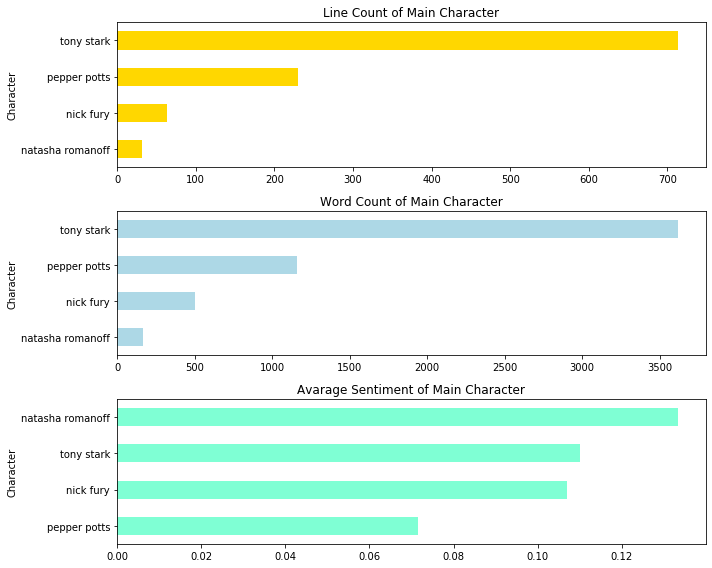

In [7]:
f= open(r'iron_man_2_script.txt', encoding="UTF-8-sig")
ironman2= f.readlines()
f.close()

get_sentiment(ironman2)